In [2]:
# Track import functions
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from pydmd.plotter import plot_modes_2D
from pydmd import DMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing

def parse_trackmate_xml(xml_path):
    """
    Parse TrackMate XML file and extract particle tracks.
    
    Parameters:
    xml_path (str): Path to the TrackMate XML file
    
    Returns:
    DataFrame: Contains all particle tracks with their positions over time
    """
    # Parse XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # List to store all particle data
    all_particles = []
    
    # Iterate through each particle track
    j = 0
    for particle in root.findall('./particle'):        
        # Process each row (timepoint) for this particle
        for row in particle.findall('./detection'):
            particle_data = {
                'particle_id': j,
                'timestamp': float(row.get('t')),
                'x': float(row.get('x')),
                'y': float(row.get('y')),
            }
            all_particles.append(particle_data)
        j+=1
    
    # Convert to DataFrame
    df = pd.DataFrame(all_particles)
    
    # Sort by particle_id and timestamp
    df = df.sort_values(['particle_id', 'timestamp'])
    
    return df

# Track Interpolation Functions
def interpolate_tracks(df, max_timesteps=890):
    """
    Interpolate missing timesteps in particle tracks, maintaining existing data
    and only filling gaps with increments of 1.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing particle tracks with columns 
                      ['particle_id', 'timestamp', 'x', 'y', 'z']
    max_timesteps (int): Maximum number of timesteps expected (0 to max_timesteps-1)
    
    Returns:
    pd.DataFrame: DataFrame with interpolated tracks
    """
    # Create a list to store interpolated data for each particle
    interpolated_data = []
    
    # Get unique particle IDs
    particle_ids = df['particle_id'].unique()
    
    # Process each particle
    for particle_id in particle_ids:
        # Get data for this particle
        particle_data = df[df['particle_id'] == particle_id].copy()
        
        # Create a DataFrame with all timesteps from 0 to max_timesteps-1
        all_timesteps = pd.DataFrame({
            'timestamp': range(max_timesteps),
            'particle_id': particle_id
        })
        
        # Merge with actual data
        merged = pd.merge(all_timesteps, particle_data, 
                         on=['particle_id', 'timestamp'], 
                         how='left')
        
        # Interpolate missing values
        merged['x'] = merged['x'].interpolate(method='linear')
        merged['y'] = merged['y'].interpolate(method='linear')
        
#         # Only keep rows between first and last actual measurements
#         first_measurement = particle_data['timestamp'].min()
#         last_measurement = particle_data['timestamp'].max()
#         merged = merged[
#             (merged['timestamp'] >= first_measurement) & 
#             (merged['timestamp'] <= last_measurement)
#         ]
        
        interpolated_data.append(merged)
    
    # Combine all interpolated tracks
    interpolated_df = pd.concat(interpolated_data, ignore_index=True)
    
    # Sort by particle_id and timestamp
    interpolated_df = interpolated_df.sort_values(['particle_id', 'timestamp'])
    
    # Calculate statistics about interpolation
    stats = calculate_interpolation_stats(df, interpolated_df)
    print_interpolation_stats(stats)
    
    return interpolated_df

def calculate_interpolation_stats(original_df, interpolated_df):
    """
    Calculate statistics about the interpolation process.
    """
    stats = {
        'original_rows': len(original_df),
        'interpolated_rows': len(interpolated_df),
        'particles': len(original_df['particle_id'].unique()),
        'added_points': len(interpolated_df) - len(original_df)
    }
    
    # Calculate gaps filled per particle
    particle_stats = []
    gap_sizes = []
    for particle_id in original_df['particle_id'].unique():
        # Original timestamps for this particle
        orig_times = set(original_df[original_df['particle_id'] == particle_id]['timestamp'])
        
        # Get all timestamps after interpolation
        interp_times = set(interpolated_df[interpolated_df['particle_id'] == particle_id]['timestamp'])
        
        # Calculate gaps
        filled_points = len(interp_times - orig_times)
        total_points = len(interp_times)
        
        # Calculate gap sizes
        orig_times_list = sorted(list(orig_times))
        for i in range(len(orig_times_list) - 1):
            gap = orig_times_list[i + 1] - orig_times_list[i] - 1
            if gap > 0:
                gap_sizes.append(gap)
        
        particle_stats.append((filled_points / total_points) * 100)
    
    stats['avg_interpolated_percentage'] = np.mean(particle_stats)
    stats['max_interpolated_percentage'] = np.max(particle_stats)
    stats['avg_gap_size'] = np.mean(gap_sizes) if gap_sizes else 0
    stats['max_gap_size'] = np.max(gap_sizes) if gap_sizes else 0
    
    return stats

def print_interpolation_stats(stats):
    """
    Print statistics about the interpolation process.
    """
    print("\nInterpolation Statistics:")
    print(f"Original number of points: {stats['original_rows']}")
    print(f"Interpolated number of points: {stats['interpolated_rows']}")
    print(f"Number of particles: {stats['particles']}")
    print(f"Added points: {stats['added_points']}")
    print(f"Average percentage of interpolated points per particle: {stats['avg_interpolated_percentage']:.2f}%")
    print(f"Maximum percentage of interpolated points for any particle: {stats['max_interpolated_percentage']:.2f}%")
    print(f"Average gap size: {stats['avg_gap_size']:.2f}")
    print(f"Maximum gap size: {stats['max_gap_size']}")


In [11]:
# DMD functions
import cv2
import numpy as np
from tqdm import tqdm
from pydmd.plotter import plot_summary
from pydmd import DMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing

def read_video_frames(video_path):
    """
    Read frames from a video and return them as a generator of 2D numpy arrays.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        yield gray_frame.astype(np.float64)

    cap.release()

def video_to_matrix(video_generator, frame_shape, total_frames):
    """
    Convert video frames from a generator into a memory-efficient matrix where each column is a flattened frame.
    """
    data_matrix = np.memmap(
        "temp_data_matrix.dat", dtype=np.float64, mode="w+", shape=(np.prod(frame_shape), total_frames)
    )

    for idx, frame in enumerate(tqdm(video_generator, total=total_frames, desc="Converting video to matrix")):
        data_matrix[:, idx] = frame.flatten()

    return data_matrix, frame_shape

def video_to_matrix_3d(video_generator, frame_shape, total_frames):
    
    data_matrix = []
    for idx, frame in enumerate(tqdm(video_generator, total=total_frames, desc="Converting video to matrix")):
        data_matrix.append(frame) 

    return data_matrix, frame_shape

def reconstruct_and_save_video(dmd_modes, dmd_dynamics, frame_shape, output_path, fps):
    """
    Reconstruct video frames from DMD modes and dynamics and save the video.
    """
    reconstructed_frames = dmd_modes.dot(dmd_dynamics).real
    reconstructed_frames = reconstructed_frames.T

    height, width = frame_shape
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=False)

    for frame in tqdm(reconstructed_frames, desc="Saving reconstructed video"):
        reshaped_frame = frame.reshape(frame_shape)
        out.write(cv2.normalize(reshaped_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))

    out.release()

def save_modes_as_videos(dmd, frame_shape, fps):
    """
    Save each spatial and temporal mode as separate videos.
    """
    print("Saving spatial modes as videos...")
    for i, mode in enumerate(tqdm(dmd.modes.T, desc="Saving spatial modes")):
        height, width = frame_shape
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        out = cv2.VideoWriter(f"./Data/010925/dmd_test/spatial_mode_{i}.avi", fourcc, fps, (width, height), isColor=False)

        mode_frame = mode.real.reshape(frame_shape)
        out.write(cv2.normalize(mode_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))
        out.release()

    print("Saving temporal modes as videos...")
    for i, dynamic in enumerate(tqdm(dmd.dynamics, desc="Saving temporal modes")):
        height, width = frame_shape
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        out = cv2.VideoWriter(f"./Data/010925/dmd_test/temporal_mode_{i}.avi", fourcc, fps, (width, height), isColor=False)

        for val in dynamic:
            temporal_frame = np.full(frame_shape, val.real)
            out.write(cv2.normalize(temporal_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))
        out.release()

def compute_projections(data_matrix, dmd):
    """
    Compute the projection of the original data onto the DMD modes.
    """
    projection = dmd.modes @ np.linalg.pinv(dmd.modes) @ data_matrix
    return projection

def save_projection_as_video(projection, frame_shape, output_path, fps):
    """
    Save the projection of the original data onto the DMD modes as a video.
    """
    reconstructed_frames = projection.real.T

    height, width = frame_shape
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=False)

    for frame in tqdm(reconstructed_frames, desc="Saving projection video"):
        reshaped_frame = frame.reshape(frame_shape)
        out.write(cv2.normalize(reshaped_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))

    out.release()

# if __name__ == "__main__":
#     video_path = "./Data/010925/010925_2_combined_500_shifted.avi"  # Path to your input video
#     output_path = "./Data/010925//dmd_test/reconstructed_video.avi"  # Path for saving the output video
#     projection_output_path = "./Data/010925/dmd_test/projection_video.avi"  # Path for saving the projection video
#     fps = 30  # Frames per second of the output video

# #     print("Reading video frames...")

# #     # Initialize video capture to read the first frame and total frames
# #     cap = cv2.VideoCapture(video_path)
# #     if not cap.isOpened():
# #         print(f"Error: Cannot open video file {video_path}")
# #         exit(1)

# #     # Read the first frame for shape
# #     ret, first_frame = cap.read()
# #     if not ret:
# #         print("Error: Could not read the first frame of the video.")
# #         cap.release()
# #         exit(1)

# #     frame_shape = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY).shape
# #     total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# #     cap.release()

# #     # Create video generator
# #     video_generator = read_video_frames(video_path)

# #     print("Converting video frames to matrix...")
# #     data_matrix, frame_shape = video_to_matrix(video_generator, frame_shape, total_frames)

# #     print("Performing Dynamic Mode Decomposition (DMD)...")
# #     dmd = DMD()
# #     dmd.fit(data_matrix)

# #     plot_summary(
# #         dmd, # <-- Fitted PyDMD model. Can be DMD, BOPDMD, etc.
# #         figsize=(12, 7),
# #         index_modes=(0, 2, 4),
# #         snapshots_shape=(449, 199),
# #         order="F",
# #         mode_cmap="seismic",
# #         dynamics_color="k",
# #         flip_continuous_axes=True,
# #         max_sval_plot=300,
# #     )

#     print("Reconstructing and saving video frames using DMD...")
#     reconstruct_and_save_video(dmd.modes, dmd.dynamics, frame_shape, output_path, fps)

#     print("Saving spatial and temporal modes as videos...")
#     save_modes_as_videos(dmd, frame_shape, fps)

#     print("Computing projection of original data onto DMD modes...")
#     projection = compute_projections(data_matrix, dmd)

#     print("Saving projection video...")
#     save_projection_as_video(projection, frame_shape, projection_output_path, fps)

#     print("All outputs saved.")


In [42]:
# Center Robot
import cv2
import numpy as np
import os

def shift_frame(frame, shift_x, shift_y):
    """Shift the given frame by (shift_x, shift_y), filling empty areas with black."""
    height, width = frame.shape[:2]
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    shifted_frame = cv2.warpAffine(frame, translation_matrix, (width, height), borderValue=(0, 0, 0))
    return shifted_frame

def stabilize_video(input_video_path, output_video_path, object_centers):
    """Stabilize video to keep the object at the center of the frame."""
    # Open the input video
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        raise ValueError("Error: Could not open video file.")

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Check if the number of object_centers matches the number of frames
    if len(object_centers) != frame_count:
        cap.release()
        raise ValueError("Error: The number of object centers must match the number of frames in the video.")

    # Define the codec and create the VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    # Center of the frame
    frame_center_x = frame_width // 2
    frame_center_y = frame_height // 2

    # Process each frame
    for i, (object_x, object_y) in enumerate(object_centers):
        ret, frame = cap.read()
        if not ret:
            print(f"Warning: Could not read frame {i}. Stopping.")
            break

        # Calculate shifts to center the object
        shift_x = frame_center_x - object_x
        shift_y = frame_center_y - object_y

        # Shift the frame
        stabilized_frame = shift_frame(frame, shift_x, shift_y)

        # Write the stabilized frame to the output video
        out.write(stabilized_frame)
#         print(f"Stabilized frame {i + 1}/{frame_count}")

    # Release resources
    cap.release()
    out.release()
    print(f"Stabilized video saved to {output_video_path}")

# Example usage
if __name__ == "__main__":
    input_video = "./Data/010625/010625_4_combined.avi"  # Path to your input video
    output_video = "./Data/010625/010625_4_combined_shifted.avi"  # Path for saving the output video

    shifts = []
    for i in range(len(robot_df)):
#         shifts.append( (100,100))
        shifts.append( (robot_df.iloc[i]["centroid_x"] , -robot_df.iloc[i]["centroid_y"]+1000))

    if os.path.exists(input_video):
        try:
            stabilize_video(input_video, output_video, shifts)
        except ValueError as e:
            print(e)
    else:
        print(f"Input video file '{input_video}' not found.")


Stabilized video saved to ./Data/010625/010625_4_combined_shifted.avi


In [37]:
robot_df

,timestamp,1_angle,1_x,1_y,2_angle,2_x,2_y,3_angle,3_x,3_y,...,6_y,centroid_x,centroid_y,body_angle,1_dist,2_dist,3_dist,4_dist,5_dist,6_dist
0,0.000000,0.613544,1120.0,779.0,-0.706091,948.0,753.0,-0.455648,981.0,637.0,...,814.0,1053.857143,710.285714,-2.364194,88.391176,116.056021,110.317723,123.081274,111.789982,107.018690
1,0.033333,0.613544,1120.0,779.0,-0.706091,948.0,753.0,-0.455648,981.0,637.0,...,814.0,1053.857143,710.285714,-2.364194,88.391176,116.056021,110.317723,123.081274,111.789982,107.018690
2,0.066667,0.710610,1120.0,780.0,-0.698219,948.0,753.0,-0.447776,981.0,637.0,...,814.0,1053.857143,710.428571,-2.372066,89.106678,116.056021,110.317723,123.081274,111.789982,107.018690
3,0.100000,0.702738,1120.0,780.0,-0.706091,948.0,753.0,-0.455648,981.0,637.0,...,814.0,1053.857143,710.571429,-2.364194,88.391176,115.741090,111.036030,124.040316,112.160599,106.103723
4,0.133333,0.702738,1120.0,780.0,-0.706091,948.0,753.0,-0.455648,981.0,637.0,...,814.0,1053.857143,710.571429,-2.364194,88.391176,115.741090,111.036030,124.040316,112.160599,106.103723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,33.166667,-1.713228,684.0,717.0,2.236770,849.0,565.0,1.357057,939.0,657.0,...,598.0,811.571429,685.571429,1.784535,132.003788,129.120099,130.000000,121.655251,117.324337,130.115333
996,33.200000,-1.713228,684.0,717.0,2.236770,849.0,565.0,1.357057,939.0,657.0,...,598.0,811.571429,685.571429,1.784535,132.003788,129.120099,130.000000,121.655251,117.324337,130.115333
997,33.233333,-1.713228,684.0,717.0,2.236770,849.0,565.0,1.357057,939.0,657.0,...,598.0,811.571429,685.571429,1.784535,132.003788,129.120099,130.000000,121.655251,117.324337,130.115333
998,33.266667,-1.713228,684.0,717.0,2.236770,849.0,565.0,1.357057,939.0,657.0,...,598.0,811.571429,685.571429,1.784535,132.003788,129.120099,130.000000,121.655251,117.324337,130.115333


In [43]:
video_path = "./Data/010625/010625_4_combined_200_shifted.avi"  # Path to your input video
print("Reading video frames...")

# Initialize video capture to read the first frame and total frames
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Error: Cannot open video file {video_path}")
    exit(1)

# Read the first frame for shape
ret, first_frame = cap.read()
if not ret:
    print("Error: Could not read the first frame of the video.")
    cap.release()
    exit(1)

frame_shape = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY).shape
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

# Create video generator
video_generator = read_video_frames(video_path)

print("Converting video frames to matrix...")
data_matrix, frame_shape = video_to_matrix_3d(video_generator, frame_shape, total_frames)

Reading video frames...
Converting video frames to matrix...


Converting video to matrix: 100%|██████████████| 890/890 [00:01<00:00, 727.29it/s]


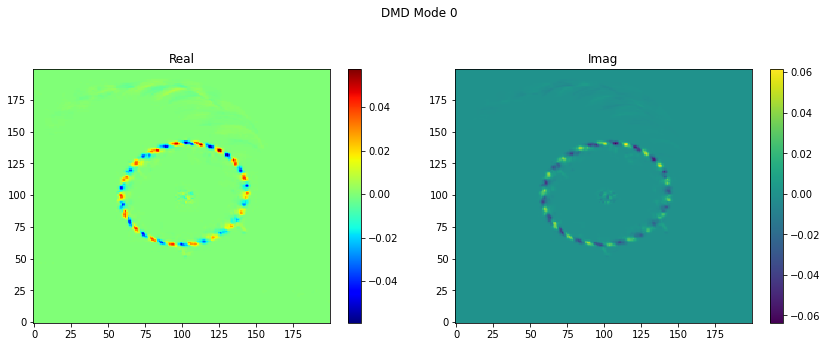

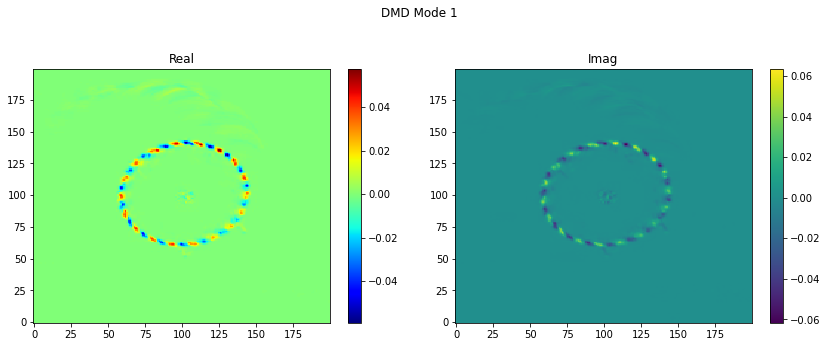

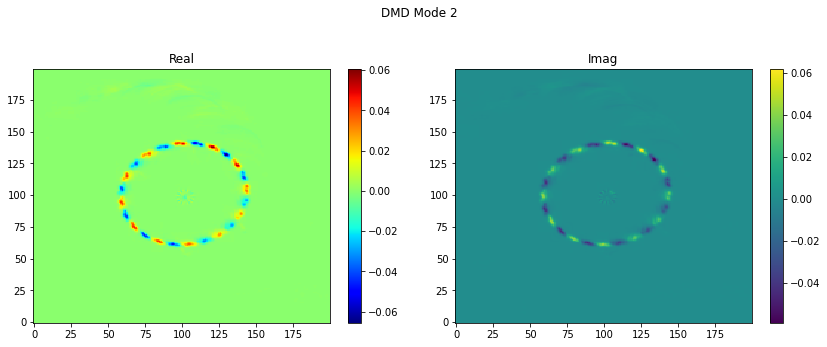

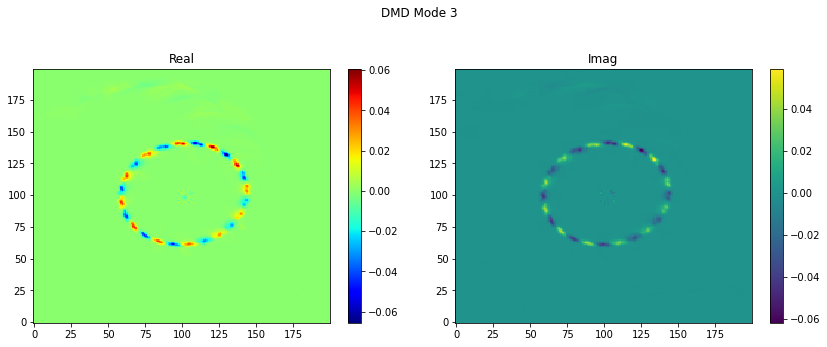

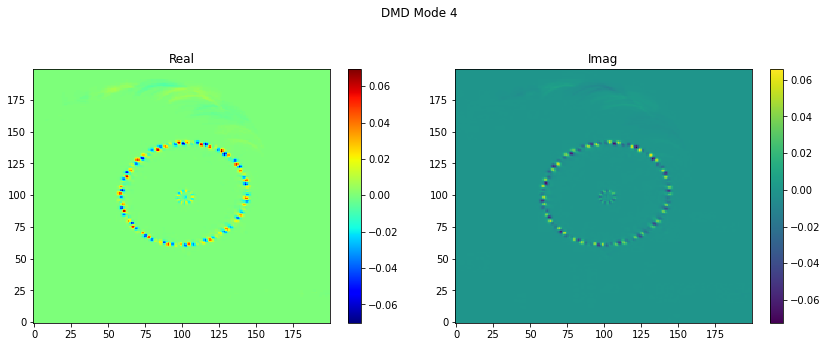

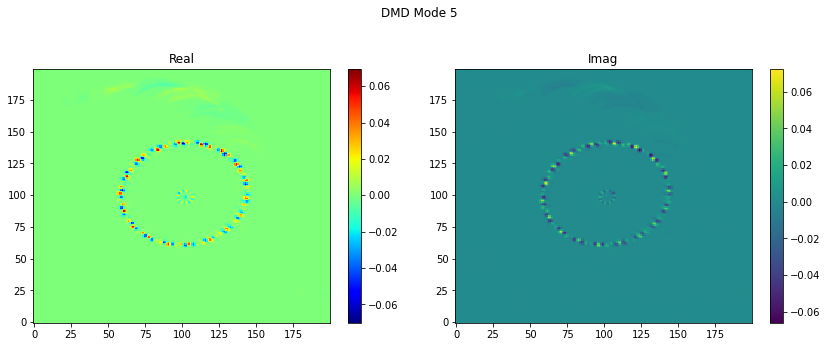

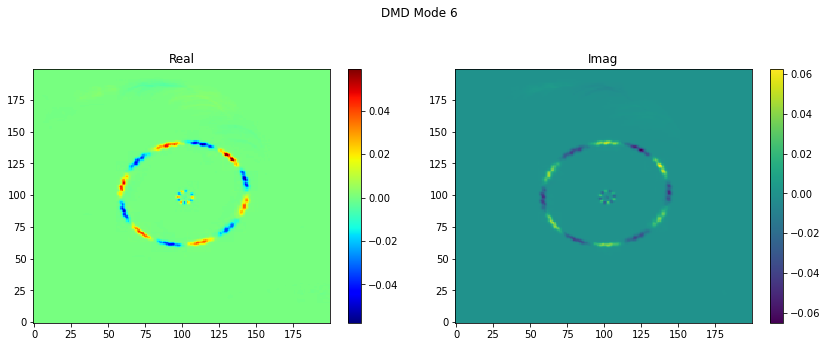

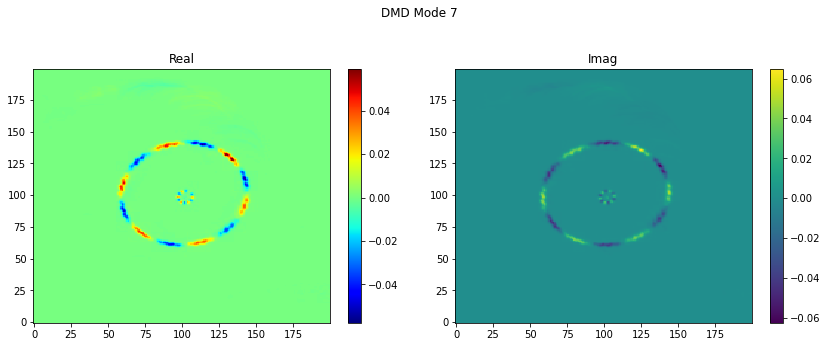

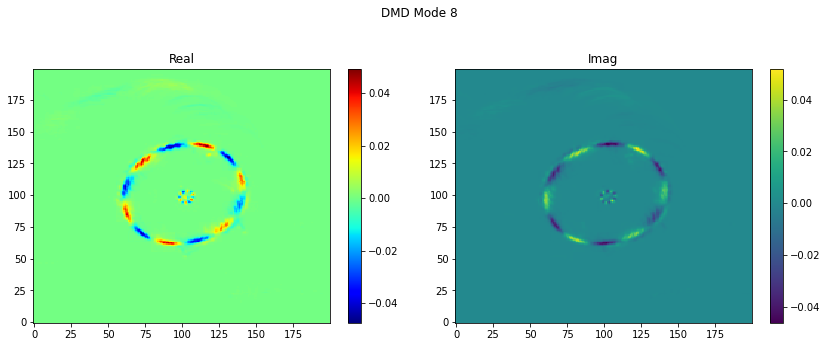

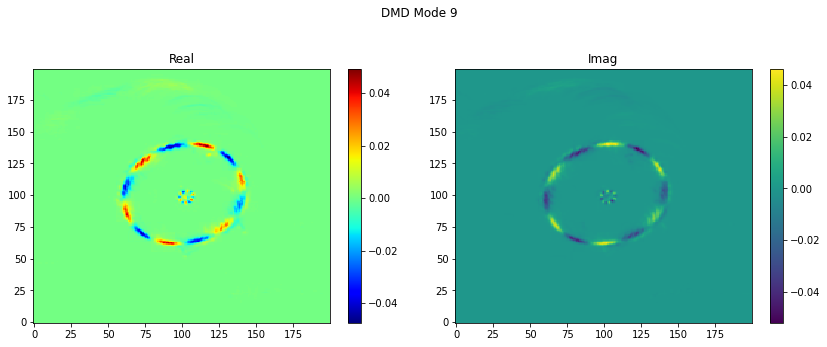

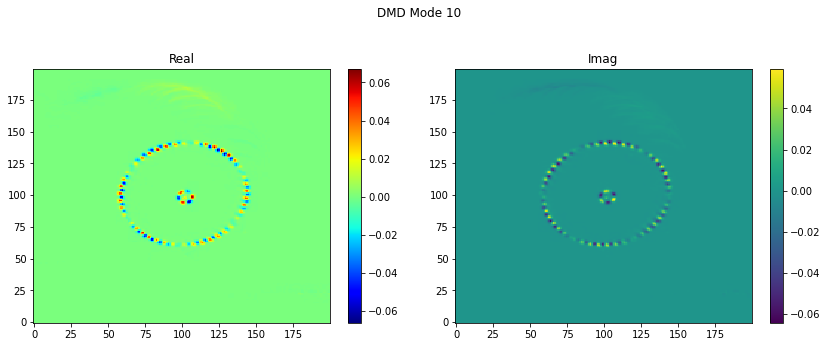

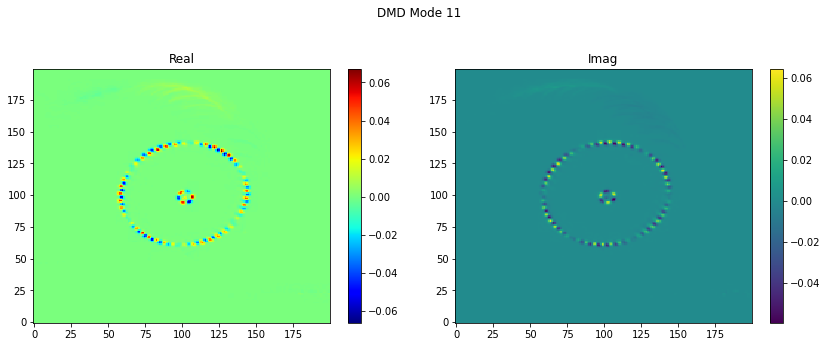

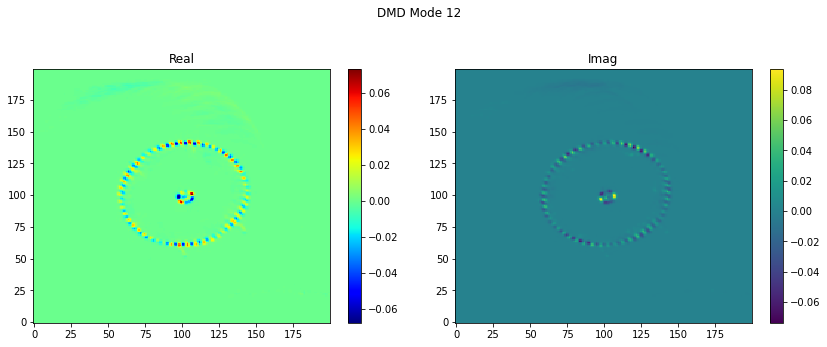

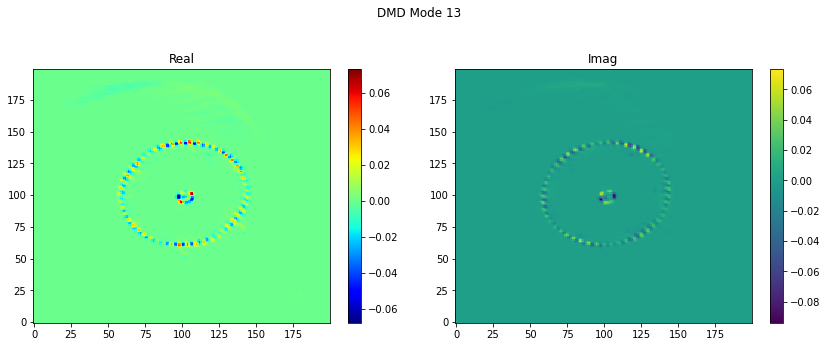

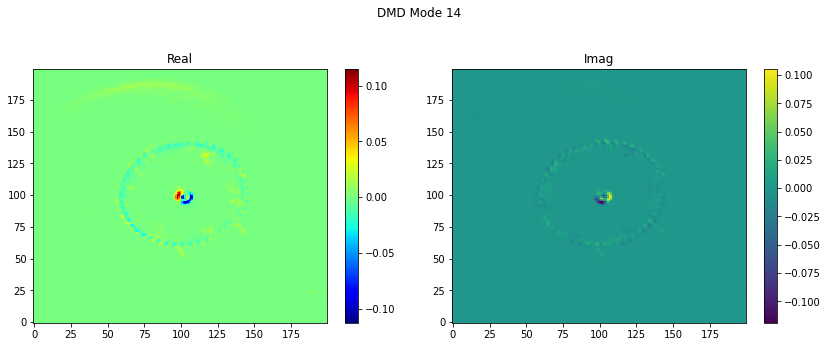

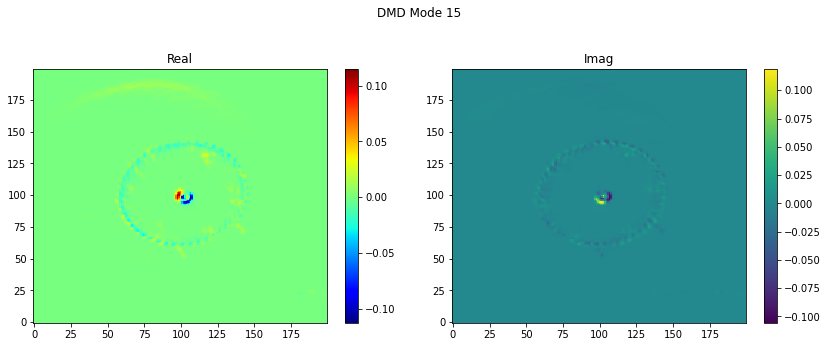

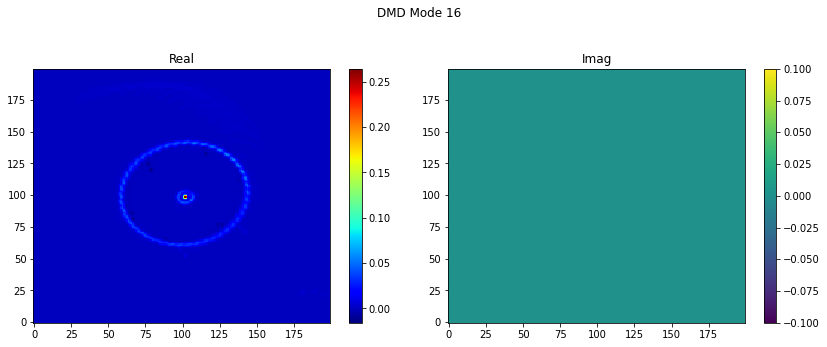

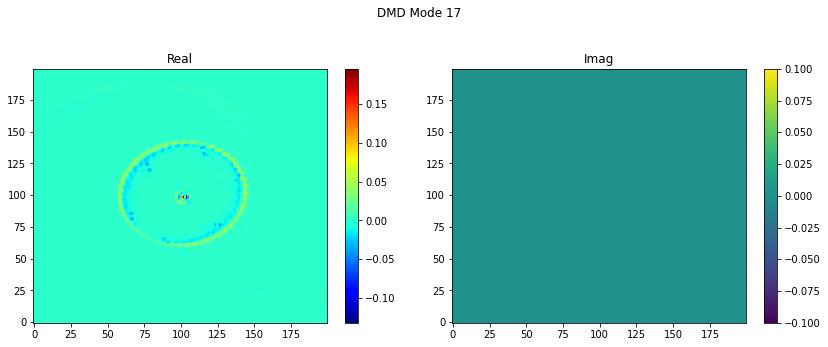

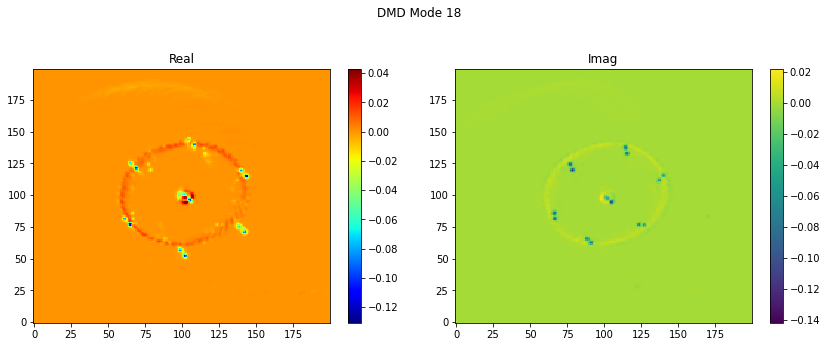

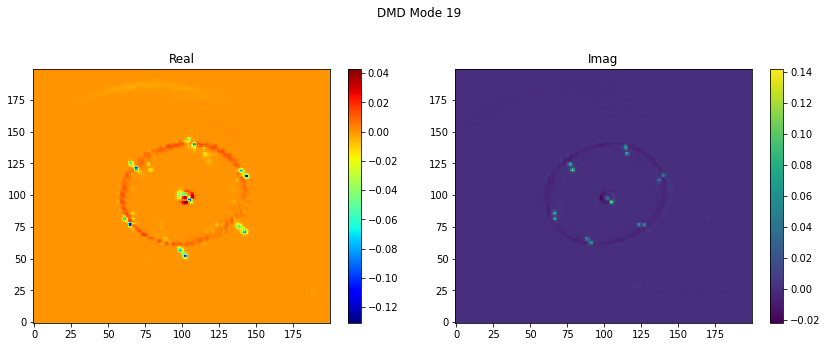

In [44]:
dmd = DMD(svd_rank = 20, exact=True, opt=True)
dmd.fit(data_matrix)
plot_modes_2D(dmd, figsize=(12, 5))

In [45]:
d = 6
t = range(1000)
# Build the Optimized DMD model.
# num_trials=0 gives Optimized DMD, without bagging.
optdmd = BOPDMD(svd_rank = 20, num_trials=3)
optdmd.fit(data_matrix, t)
# # Wrap the model with the preprocessing routine.
# delay_optdmd = hankel_preprocessing(optdmd, d=d)

# # Fit the model to the noisy data.
# # Note: BOPDMD models need the data X and the times of data collection t for fitting.
# # Hence if we apply time-delay, we must adjust the length of our time vector accordingly.
# delay_t = t[: -d + 1]
# delay_optdmd.fit(data_matrix, t=delay_t)

ValueError: The number of columns in the data matrix X must match the number of time points in the time vector t.

In [ ]:
plot_modes_2D(optdmd, figsize=(12, 5))

In [40]:
# Generate data matrix
# centers_xml = "./Data/010925/010925_2_green_Tracks.xml"
# indicator_xml = "./Data/010925/010925_2_orange_Tracks.xml"

# centers_xml = "./Data/010925/010925_1_green_Tracks.xml"
# indicator_xml = "./Data/010925/010925_1_orange_Tracks.xml"

# x_window = 1000
# y_window = 1000

centers_xml = "./Data/010625/010625_4_green_Tracks.xml"
indicator_xml = "./Data/010625/010625_4_orange_Tracks.xml"
x_window = 1500
y_window = 1003

centers_spots_df = parse_trackmate_xml(centers_xml)
indicator_spots_df = parse_trackmate_xml(indicator_xml)

# now interpolate so they all have the same length
nFrames = 890
centers = interpolate_tracks(centers_spots_df, max_timesteps=nFrames)
indicators = interpolate_tracks(indicator_spots_df, max_timesteps=nFrames)

# link centers and indicator based closest initial position
pair_ids = [] # list of tuples. first value is center particle_id and second is indicator particle_id

center_ids = centers['particle_id'].unique() 
indicator_ids = indicators['particle_id'].unique()

for center_id in center_ids:
    min_dist = 10000000
    min_id = 10
    df1 = centers[centers['particle_id'] == center_id].copy()
    
    for indicator_id in indicator_ids:
        df2 = indicators[indicators['particle_id'] == indicator_id].copy()
        dist = np.sqrt( (df1.iloc[0]["x"] - df2.iloc[0]["x"])**2 + (df1.iloc[0]["y"] - df2.iloc[0]["y"])**2  )
        if dist < min_dist:
            min_dist = dist
            min_id = indicator_id
    
    pair_ids.append((center_id,min_id, min_dist))
    
# Now make a dataframe for each node, store in list
node_list = []
#pair_ids = [(0,5) , (1,0), (2,2), (3,3), (4,4), (5,1), (6,6)]
for pair in pair_ids:
    center_id = pair[0]
    indicator_id = pair[1]
    
    df1 = centers[centers['particle_id'] == center_id]
    df2 = indicators[indicators['particle_id'] == indicator_id]
    t   = np.array(df1["timestamp"])
    x   = np.array(df1["x"])
    y   = -np.array(df1["y"])+y_window
    x2  = np.array(df2["x"])
    y2  = -np.array(df2["y"])+y_window # flip y direction to match video
    
    
    data = {"timestamp":t, "node_id":center_id,"center_x":x, "center_y":y, "indicator_x":x2, "indicator_y":y2 }
    node_list.append(pd.DataFrame(data))
    
# add indicator data
for node in node_list:
    dists = []
    angles = []
    for row in node.iterrows():
        dx = row[1]["center_x"] - row[1]["indicator_x"]
        dy = row[1]["center_y"] - row[1]["indicator_y"]
        dists.append(np.sqrt( (dx)**2 + (dy)**2  ))
        angles.append( np.atan2( dx, dy) )
    node["indicator_dist"] = dists
    node["indicator_angles"] = angles
    
# determine central node to make body reference frame, then relabel nodes so 0 is in center, 1 defines line and increases clockwise
min_dist = 100000000
min_node = 0
for node in node_list:
    total_dist = 0
    for other_node in node_list:
        total_dist += np.sqrt( (node.iloc[0]["center_x"] - other_node.iloc[0]["center_x"])**2 + 
                              (node.iloc[0]["center_y"] - other_node.iloc[0]["center_y"])**2  )
    if total_dist < min_dist:
        min_dist = total_dist
        min_node = node
        
# pick another node to make a line. Frame will be right hand ruled off that. wont be perfect since whole thing
# is deforming
frame = (min_node, 1) # other node picked randomly by hand
body_angle = []
for t in min_node["timestamp"]:
    dx = min_node.iloc[t]["center_x"] - node_list[0].iloc[t]["center_x"]
    dy = min_node.iloc[t]["center_y"] - node_list[0].iloc[t]["center_y"]
    body_angle.append(np.atan2( dx, dy))
    
# Get rotated angles based on body frame
for node in node_list:
    rotated = []
    for t in node["timestamp"]:
        theta = body_angle[t]
        rot_matrix = np.array( [ [np.cos(theta), -np.sin(theta)] , [np.sin(theta), np.cos(theta)] ] )
        x1 = node.iloc[t]["center_x"]
        x2 = node.iloc[t]["indicator_x"]
        y1 = node.iloc[t]["center_y"]
        y2 = node.iloc[t]["indicator_y"]

        p1 = np.array([x1,y1])
        p2 = np.array([x2,y2])

        r1 = rot_matrix@p1
        r2 = rot_matrix@p2

        dx = r1[0]-r2[0]
        dy = r1[1]-r2[1]

        rotated.append(np.atan2( dx, dy))
    node["in_frame_angle"] = rotated
    
# Generate data frame for robot. node ID's get moved around!!!!! 0 is center

fr = 30 #hz

robot_df = pd.DataFrame(min_node["timestamp"]/fr)
i = 1
min_node_id = min_node.iloc[0]["node_id"]

plt.figure(figsize=(10,10))
for node in node_list:
    disp = []
    node_id = int(node.iloc[0]["node_id"])
    x0 = node.iloc[0]["center_x"]
    y0 = node.iloc[0]["center_y"]

    for t in node["timestamp"]:
        disp.append( np.sqrt( (node.iloc[t]["center_x"] - x0)**2 + (node.iloc[t]["center_y"] - y0)**2 ) )
    if node_id == min_node_id:
        label = str(0)
    else:
        label = str(i)
        i+=1
        
    robot_df[label+"_angle"] = node["in_frame_angle"]
    # robot_df[str(i)+"_disp"] = disp 
    robot_df[label+"_x"] = node["center_x"]
    robot_df[label+"_y"] = node["center_y"]
    
#     plt.text(x0, y0, label, color="blue", fontsize=10)
#     plt.scatter(x0,y0)


# calculate centroid at each time point
xcent = []
ycent = []
num_nodes = len(node_list)
for t in range(len(robot_df)):
    xsum = 0
    ysum = 0
    for node in node_list:
        xsum += node.iloc[t]["center_x"] / num_nodes
        ysum += node.iloc[t]["center_y"] / num_nodes
    xcent.append(xsum)
    ycent.append(ysum)
    
robot_df["centroid_x"] = xcent
robot_df["centroid_y"] = ycent
robot_df["body_angle"] = body_angle

# get distance between center node and edge nodes

for i in range(1,len(node_list)):
    dist = []
    for t in range(len(robot_df)):
        dist.append(np.sqrt((robot_df.iloc[t][str(i)+"_x"] - robot_df.iloc[t]["0_x"])**2 
                             + (robot_df.iloc[t][str(i)+"_y"] - robot_df.iloc[t]["0_y"])**2 ) )
    robot_df[str(i)+"_dist"] = dist



Interpolation Statistics:
Original number of points: 6128
Interpolated number of points: 6230
Number of particles: 7
Added points: 102
Average percentage of interpolated points per particle: 1.64%
Maximum percentage of interpolated points for any particle: 2.36%
Average gap size: 2.00
Maximum gap size: 10.0

Interpolation Statistics:
Original number of points: 6045
Interpolated number of points: 6230
Number of particles: 7
Added points: 185
Average percentage of interpolated points per particle: 2.97%
Maximum percentage of interpolated points for any particle: 4.94%
Average gap size: 2.54
Maximum gap size: 14.0


<Figure size 720x720 with 0 Axes>

In [41]:
robot_df

,timestamp,1_angle,1_x,1_y,2_angle,2_x,2_y,3_angle,3_x,3_y,...,6_y,centroid_x,centroid_y,body_angle,1_dist,2_dist,3_dist,4_dist,5_dist,6_dist
0,0.000000,0.613544,1120.0,779.0,-0.706091,948.0,753.0,-0.455648,981.0,637.0,...,814.0,1053.857143,710.285714,-2.364194,88.391176,116.056021,110.317723,123.081274,111.789982,107.018690
1,0.033333,0.613544,1120.0,779.0,-0.706091,948.0,753.0,-0.455648,981.0,637.0,...,814.0,1053.857143,710.285714,-2.364194,88.391176,116.056021,110.317723,123.081274,111.789982,107.018690
2,0.066667,0.710610,1120.0,780.0,-0.698219,948.0,753.0,-0.447776,981.0,637.0,...,814.0,1053.857143,710.428571,-2.372066,89.106678,116.056021,110.317723,123.081274,111.789982,107.018690
3,0.100000,0.702738,1120.0,780.0,-0.706091,948.0,753.0,-0.455648,981.0,637.0,...,814.0,1053.857143,710.571429,-2.364194,88.391176,115.741090,111.036030,124.040316,112.160599,106.103723
4,0.133333,0.702738,1120.0,780.0,-0.706091,948.0,753.0,-0.455648,981.0,637.0,...,814.0,1053.857143,710.571429,-2.364194,88.391176,115.741090,111.036030,124.040316,112.160599,106.103723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,29.500000,-1.778267,685.0,652.0,2.437270,911.0,603.0,1.338121,933.0,725.0,...,565.0,812.000000,687.000000,1.284325,134.480482,130.299655,124.040316,118.456743,124.470880,128.097619
886,29.533333,-1.749891,681.0,668.0,2.370564,899.0,590.0,1.302318,938.0,710.0,...,569.0,812.142857,686.714286,1.406867,134.807270,131.244047,125.602548,118.330047,122.380554,129.448832
887,29.566667,-1.730896,680.0,685.0,2.322901,884.0,579.0,1.410697,940.0,692.0,...,576.0,812.285714,686.285714,1.533500,134.093251,131.228808,126.015872,118.701306,121.247680,130.249760
888,29.600000,-1.728024,681.0,701.0,2.281662,867.0,571.0,1.347585,941.0,675.0,...,587.0,811.857143,686.000000,1.661456,132.544332,129.769026,128.763349,121.037184,118.962179,129.015503


In [35]:
data_df=pd.DataFrame()
for i in range(len(node_list)):
    data_df[str(i)+"_angle"] = robot_df[str(i)+"_angle"]
    data_df[str(i)+"_x"] = robot_df[str(i)+"_x"] - robot_df["centroid_x"]
    data_df[str(i)+"_y"] = robot_df[str(i)+"_y"] - robot_df["centroid_y"]
                                                            
data_df["body_angle"] = robot_df["body_angle"]
data = data_df.to_numpy()

In [ ]:
i = 1
data_df

In [ ]:
# Build the Optimized DMD model.
# num_trials=0 gives Optimized DMD, without bagging.
optdmd = BOPDMD(svd_rank=4, num_trials=0)
d = 10
t = np.array(robot_df["timestamp"])
# Wrap the model with the preprocessing routine.
delay_optdmd = hankel_preprocessing(optdmd, d=d)

# Fit the model to the noisy data.
# Note: BOPDMD models need the data X and the times of data collection t for fitting.
# Hence if we apply time-delay, we must adjust the length of our time vector accordingly.

delay_t = t[: -d + 1]
delay_optdmd.fit(data.T, t=delay_t)

# Plot a summary of the DMD results.
plot_summary(delay_optdmd, x=x, d=d)

In [ ]:
dmd = DMD(opt=True)
dmd.fit(data.T)

In [ ]:
plot_summary(
    dmd, # <-- Fitted PyDMD model. Can be DMD, BOPDMD, etc.
    figsize=(12, 7),
    index_modes=(0, 1, 2),
    order="F",
    mode_cmap="seismic",
    dynamics_color="k",
    flip_continuous_axes=True,
    max_sval_plot=125,
)

In [ ]:
projection = dmd.modes @ np.linalg.pinv(dmd.modes) @ data


In [ ]:
x1 = np.linspace(-3, 3, 80)
x2 = np.linspace(-3, 3, 80)
x1grid, x2grid = np.meshgrid(x1, x2)

time = np.linspace(0, 6, 16)

data = [2 / np.cosh(x1grid) / np.cosh(x2grid) * (1.2j**-t) for t in time]
noise = [np.random.normal(0.0, 0.4, size=x1grid.shape) for t in time]

snapshots = [d + n for d, n in zip(data, noise)]

In [ ]:
np.shape(snapshots)